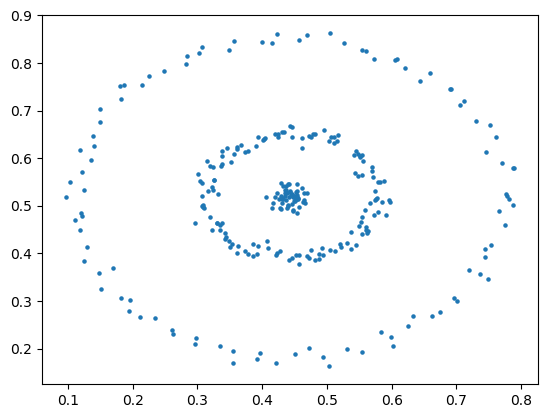

PyObject <matplotlib.collections.PathCollection object at 0x14202ec50>

In [1]:
using MAT
using PyPlot
file = matread("Data.mat")
X = file["data"] ;
scatter(X[:,1] , X[:,2] , s = 5)

In [2]:
function get_K(X , sigma)
    sigma *= 4 ;
    n = size(X,1) ; # number of points
    K = ones(n,n) ; # the diagonal entries are 1 in kernel matrix
    
    # get components of kernel matrix
    for ii = 1 : n
        for jj = ii+1 : n
            temp = sum((X[ii,:] - X[jj,:]).^2) ;
            K[ii,jj] = exp(-temp/sigma) ;
            K[jj,ii] = K[ii,jj] ; # since k(x,y) = k(y,x)
        end
    end
    
    return K ;
end

# get kernel matrix
sigma = 0.00025 ;
K = get_K(X , sigma) ;

## Diffusion distance in data space (with D metric)

In [3]:
using LinearAlgebra
function diff_Distance(K)
    # get D matrix
    n = size(K , 1) ;
    D = zeros(n , n) ;
    for ii = 1 : n
        D[ii,ii] = sum(K[ii,:]) ;
    end
    
    Dinv = inv(D) ;
    
    # get P matrix
    P = Dinv*K ;
    
    DDD = zeros(n,n) ;
    
    for ii = 1 : n
        for jj = ii+1 : n
            temp = (P[ii,:] - P[jj,:]).^2 ;
            DDD[ii,jj] = sum(Dinv * temp) ;
            DDD[jj,ii] = DDD[ii,jj] ;
        end
    end
    
    return DDD ;
end
@time DDD = diff_Distance(K);

  1.950533 seconds (2.31 M allocations: 645.938 MiB, 8.09% gc time)


## Euclidean distance in diffusion space

In [4]:
using LinearAlgebra
function eucl_Distance(K)
    # get D matrix
    n = size(K , 1) ;
    Dsq = zeros(n , n) ;
    for ii = 1 : n
        Dsq[ii,ii] = sqrt(sum(K[ii,:])) ;
    end
    
    D = Dsq.^2 ;
    Dinv = inv(D) ;
    Dsqinv = inv(Dsq) ;

    # get P' matrix
    Ppron = Dsqinv*K*Dsqinv ;

    # get eigenvalue and eigenvector
    U,S,V = svd(Ppron) ;
    
    U = Dsqinv * U ;
    
    # find diffusion matrix
    Y = zeros(n,n) ;
    for ii = 1 : n
        for jj = 1 : n
            Y[ii,jj] = S[jj] * U[ii,jj] ;
        end
    end

    # find diffusion distance matrix
    DDM = zeros(n,n) ;
    for ii = 1 : n
        for jj = ii+1 : n
            DDM[ii,jj] = sum((Y[ii,:] - Y[jj,:]).^2) ;
            DDM[jj,ii] = DDM[ii,jj] ;
        end
    end
    return DDM ;
end
@time DDM = eucl_Distance(K);

  0.620197 seconds (948.32 k allocations: 483.863 MiB, 20.91% gc time)


## Check the difference

In [5]:
A = DDM - DDD;
opnorm(A, Inf)

7.346900865456973e-14